In [2]:
%load_ext autoreload
%autoreload 2
from __future__ import print_function

# The main mapwork module
from enlib import enmap

import numpy as np
# Tools for working with enmaps, i/o, catalogs and statistics
from orphics import maps,io,stats,cosmology

from enlib import colorize, resample                                                                                                                           
colorize.mpl_setdefault("planck") 


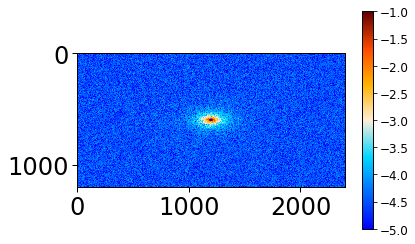

(1200, 2400)


/home/msyriac/.local/lib/python2.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log10


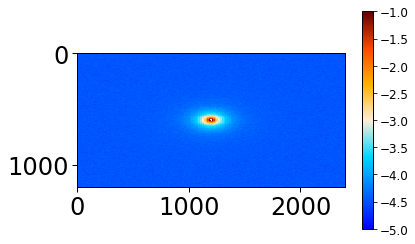

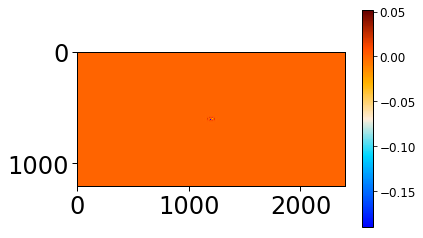

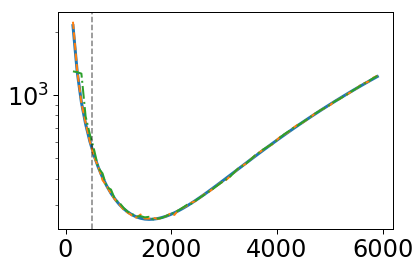

In [211]:
shape,wcs = maps.rect_geometry(width_deg=40.,height_deg=20.,px_res_arcmin=1.0)
modlmap = enmap.modlmap(shape,wcs)
modrmap = enmap.modrmap(shape,wcs)

kmask = maps.mask_kspace(shape,wcs,lmin=100)
    
def get_p2d(noisy=True):
    uk_arcmin = 20.
    lknee = 2000.
    alpha = -3.
    p2d = kmask*cosmology.white_noise_with_atm_func(modlmap,uk_arcmin,
                                                    lknee,alpha,dimensionless=False,TCMB=2.7255e6)
    if not(noisy): return p2d
    nsplits = 4
    mg = maps.MapGen(shape,wcs,p2d.reshape((1,1,shape[0],shape[1]))*nsplits)
    splits = []
    for i in range(nsplits):
        splits.append(mg.get_map())
    p2d,_ = maps.noise_from_splits(splits)    
    return p2d
    
p2d = get_p2d()
io.plot_img(np.fft.fftshift(np.log10(p2d)),lim=[-5,-1])#,lim=[-0.5,1.2])
dfact = 8
order = 1

dp2d = maps.downsample_power(shape,wcs,p2d,ndown=dfact,order=order,exp=None,fftshift=True)
io.plot_img(np.fft.fftshift(np.log10(dp2d*kmask)),lim=[-5,-1])
io.plot_img(np.fft.fftshift((dp2d*kmask-get_p2d(noisy=False)*kmask)))

bin_edges = np.arange(100,6000,80)
binner = stats.bin2D(modlmap,bin_edges)

cents,p1d = binner.bin(get_p2d(noisy=False)*kmask)
cents,n1d = binner.bin(p2d)
cents,d1d = binner.bin(dp2d)
pl = io.Plotter(yscale='log')
pl.add(cents,cents**2.*p1d,lw=3)
pl.add(cents,cents**2.*n1d,ls="--",lw=2)
pl.add(cents,cents**2.*d1d,ls="-.",lw=2)
pl.vline(x=500.)
pl.done()

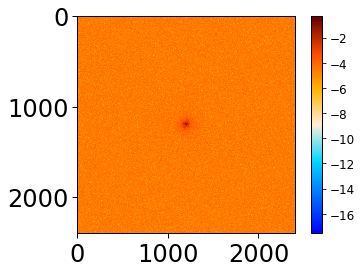

/home/msyriac/.local/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/home/msyriac/.local/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


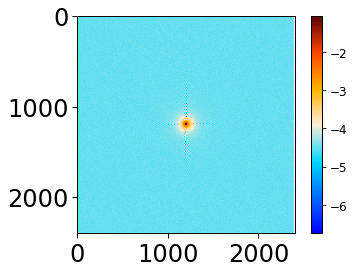

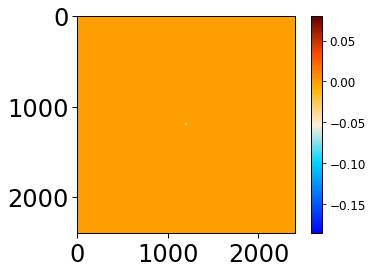

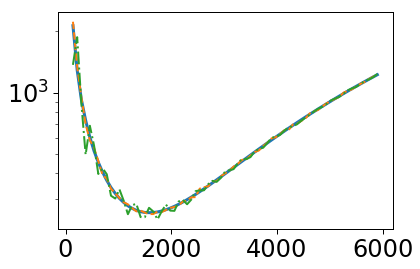

In [45]:
io.plot_img(np.fft.fftshift(np.log10(p2d)))
dp2d = maps.downsample_power(shape,wcs,p2d,ndown=dfact,order=order,exp=None,fftshift=True,fft=True)
io.plot_img(np.fft.fftshift(np.log10(dp2d)))
io.plot_img(np.fft.fftshift((dp2d-get_p2d(noisy=False))))

cents,p1d = binner.bin(get_p2d(noisy=False))
cents,n1d = binner.bin(p2d)
cents,d1d = binner.bin(dp2d)
pl = io.Plotter(yscale='log')
pl.add(cents,cents**2.*p1d,lw=3)
pl.add(cents,cents**2.*n1d,ls="--",lw=2)
pl.add(cents,cents**2.*d1d,ls="-.",lw=2)
pl.done()


In [46]:
pcov = np.zeros((3,3,shape[0],shape[1]))
for i in range(3):
    for j in range(i,3):
        pcov[i,j] = get_p2d(noisy=True)
        if i!=j: pcov[j,i] = pcov[i,j].copy()


In [48]:
pcov.shape
enmap.downgrade(pcov,4).shape

(3, 3, 600, 600)

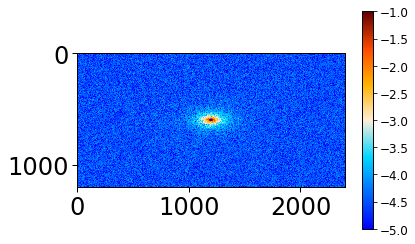

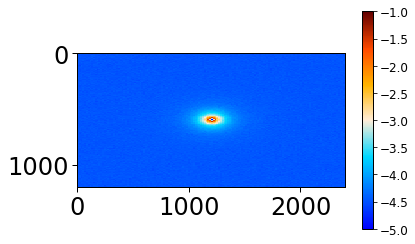

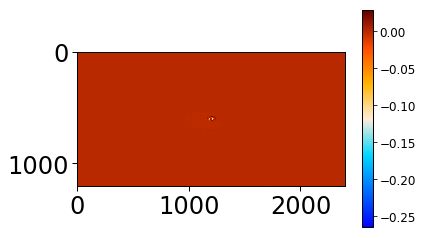

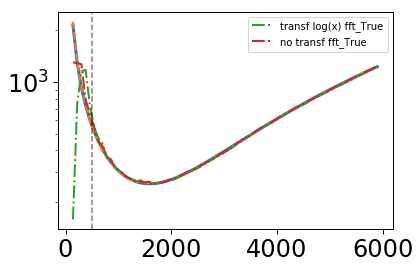

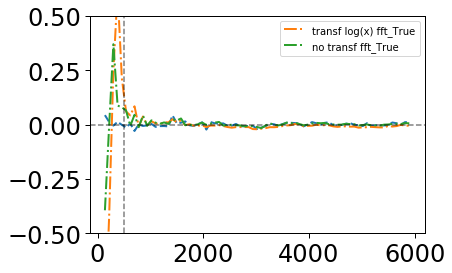

In [216]:
ellfact = 2000
#lfunc = lambda x: np.arcsinh(x*ellfact)
#ilfunc = lambda x: np.sinh(x)/ellfact
lfunc = lambda x: np.log(x)
ilfunc = lambda x: np.exp(x)

dofft = True

io.plot_img(np.fft.fftshift(np.log10(p2d)),lim=[-5,-1])
dp2d = maps.downsample_power(shape,wcs,p2d,ndown=dfact,order=order,exp=None,fftshift=True,fft=dofft,logfunc=lfunc,ilogfunc=ilfunc)*1.18
dp2d0 = maps.downsample_power(shape,wcs,p2d,ndown=dfact,order=order,exp=None,fftshift=True,fft=False)

io.plot_img(np.fft.fftshift(np.log10(dp2d)),lim=[-5,-1])
io.plot_img(np.fft.fftshift((dp2d-get_p2d(noisy=False))))

cents,p1d = binner.bin(get_p2d(noisy=False))
cents,n1d = binner.bin(p2d)
cents,d1d = binner.bin(dp2d)
cents,d1d0 = binner.bin(dp2d0)

pl = io.Plotter(yscale='log')
pl.add(cents,cents**2.*p1d,lw=3)
pl.add(cents,cents**2.*n1d,ls="--",lw=2)
#pl.add(cents,cents**2.*d1d,ls="-.",lw=2,label="transf arcsinh(400x) fft_"+str(dofft))
pl.add(cents,cents**2.*d1d,ls="-.",lw=2,label="transf log(x) fft_"+str(dofft))

pl.add(cents,cents**2.*d1d0,ls="-.",lw=2,label="no transf fft_"+str(dofft))
pl.legend(loc='upper right')
pl.vline(x=500.)
pl.done()

pl = io.Plotter()
#pl.add(cents,p1d,lw=3)
pl.add(cents,(n1d-p1d)/p1d,ls="--",lw=2)
pl.add(cents,(d1d-p1d)/p1d,ls="-.",lw=2,label="transf log(x) fft_"+str(dofft))
pl.add(cents,(d1d0-p1d)/p1d,ls="-.",lw=2,label="no transf fft_"+str(dofft))
pl.legend(loc='upper right')
pl.hline()
pl.vline(x=500.)
pl._ax.set_ylim(-0.5,0.5)
pl.done()



In [190]:
m = 100000
a = np.random.chisquare(6,m)
#print(np.mean(a))
#asq = (np.random.normal(0,1.,m)+1j*np.random.normal(0,1.,m))
#a = (asq*asq.conj()).real
print(np.mean(a)/np.exp(np.mean(np.log(a))))
print(np.mean(a)/np.sinh(np.mean(np.arcsinh(a*ellfact)))*ellfact)
print(np.mean(p2d[modlmap>10000]))
print(p2d[modlmap>5000])

1.1925494348189776
1.1925494254536235
3.3939505e-05
[2.0129693e-05 2.5044959e-05 3.9562467e-05 ... 2.5994526e-05 5.9497848e-05
 4.2896834e-05]


In [193]:
samples = p2d[modlmap>5000].ravel()
print(samples)
print(np.mean(samples)/np.exp(np.mean(np.log(samples))))

#np.save("p2d_physical_ellgthan_5000.npy",samples)

[8.1762737e-06 4.5728651e-05 4.8384874e-05 ... 6.2138170e-06 6.7953923e-05
 9.7955335e-06]
1.7812196


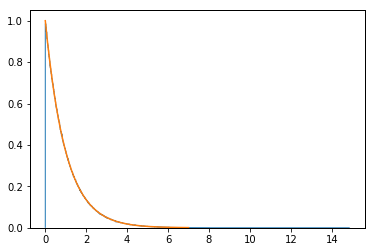

In [199]:
import scipy
import matplotlib.pyplot as plt
a = samples/np.mean(samples)
dofs = 2
x = np.linspace(0,7,1000)
plt.hist(a, bins=1000, histtype="step", density=True); plt.plot(x,scipy.stats.chi2.pdf(x*dofs,dofs)*dofs); plt.show()